In [ ]:
#for selecting vecotr of 4 use 
#random.sample(data, k=4)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import time
from numpy.random import uniform

In [2]:
#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #changes link for each
    new_G = nx.Graph()
    new_G.add_nodes_from(list(G.nodes))
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else: #same procedure, but we change second end of edge
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else: #we simply add link that existed in starting network
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    #new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    
    return new_G

''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(0,1), (0,2), (1,2)])
    for i in range(2,m0): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        pi = [nx.degree(G, nody)/(sum([nx.degree(G, n) for n in G.nodes])) for nody in G.nodes] #probability for each node
        choice_list =  np.random.choice(list(G.nodes), m, p=pi, replace=False) #choose randomly with no repetinions
        
        for link in choice_list:
            G.add_edge(link, tau+m0)
         #in case we do not link it to any node
      
    return G

## q-voter

In [3]:
#for 3 dot only save results, plots are for 4th and 5th
#for 4th dot choose some values of p, between 0.1 and 0.6, 5 values of p
#all starts with the same opinion

In [4]:
G_b = nx.barabasi_albert_graph(100, 4)

In [5]:
G_test = nx.barabasi_albert_graph(30, 4)

If we have less than q neigbours, just skip it

In [96]:
#change it into asynchronous model
def q_voter(G, q=4, p=0.5, MC_step = 10, time_horizon=10):
    nodes = list(G.nodes())
    G_size = len(nodes)
    #opinion_array = 2*np.random.randint(0,2,G_size)-1 #creates array full of either 1 or -1
    opinion_array = np.ones(G_size)
    current_time = 0
    mean_opinion = [np.mean(opinion_array)]
    time_gone = [current_time]
    while(current_time < time_horizon):
        for _ in range(MC_step):
            current_node = np.random.choice(nodes)
            if(random.random()>p): 
                try:
                    list_of_neighbours = np.random.choice(list(G.neighbors(current_node)),size=q)
                except: #not enough neigbours to force change of our decision
                    pass
                if(abs(np.mean(opinion_array[list_of_neighbours])==1)): #either all are -1 or 1 
                    opinion_array[current_node] = opinion_array[list_of_neighbours[0]] #all have the same state
                    
                #elif(random.random()<eps):
                #    print("niezgodni")
                #    opinion_array[current_node]*=-1

            else:
                opinion_array[current_node] =np.random.choice([-1,1]) #either changes or not their opinion
        current_time+=1
        mean_opinion.append(np.mean(opinion_array))
        time_gone.append(current_time)
    return mean_opinion, time_gone

In [72]:
q_voter(G_b,4,0.5,10,10)

([1.0, 0.92, 0.86, 0.8, 0.8, 0.76, 0.72, 0.72, 0.68, 0.62, 0.58],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [8]:
q_voter(Barabasi(4,4,96),4,0.5,10,10)

([0.1, 0.06, 0.08, 0.02, 0.02, 0.08, 0.1, 0.1, 0.08, 0.08, 0.18],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# 1st dot

# 2nd dot

In [130]:
# here is implemented change, that each monte carlo step consists of G_size chagnes
def q_voter_dot_2(G, q=4, p=0.5, MC_step = 10):
    nodes = list(G.nodes())
    G_size = len(nodes)
    #opinion_array = 2*np.random.randint(0,2,G_size)-1 #creates array full of either 1 or -1
    opinion_array = np.ones(G_size)
    opinions = []
    for _ in range(MC_step):
        for _ in range(G_size):
            current_node = np.random.choice(nodes)
            if(random.random()>p): 
                try:
                    list_of_neighbours = np.random.choice(list(G.neighbors(current_node)),size=q)
                except: #not enough neigbours to force change of our decision
                    pass
                if(abs(np.mean(opinion_array[list_of_neighbours])==1)): #either all are -1 or 1 
                    opinion_array[current_node] = opinion_array[list_of_neighbours[0]] #all have the same state

                    #elif(random.random()<eps):
                    #    print("niezgodni")
                    #    opinion_array[current_node]*=-1

            else:
                opinion_array[current_node] =np.random.choice([-1,1]) #either changes or not their opinion
        #opinions.append(np.mean(opinion_array))
    return np.mean(opinion_array)

In [112]:
for i in range(5):
    if(i==4):
        print(i)
    else:
        pass

4


In [123]:
q_voter_dot_2(G_w, q=3, p=p_one, MC_step=1000)

0.24276

In [131]:
ps = np.arange(0.0, 0.5, 0.02)#
ps_gw = []
for p_one in ps:
    ps_gw.append(q_voter_dot_2(G_w, q=3, p=p_one, MC_step=100))

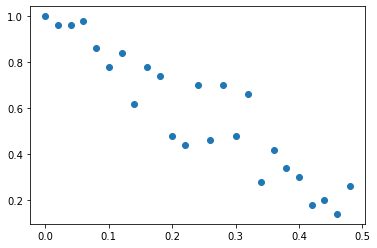

In [132]:
plt.scatter(ps, ps_gw)

# 3rd dot

In [137]:
# here is implemented change, that each monte carlo step consists of G_size chagnes
def q_voter_dot_3(G, q=4, p=0.5, MC_step = 10):
    nodes = list(G.nodes())
    G_size = len(nodes)
    #opinion_array = 2*np.random.randint(0,2,G_size)-1 #creates array full of either 1 or -1
    opinion_array = np.ones(G_size)
    opinions = []
    for _ in range(MC_step):
        for _ in range(G_size):
            current_node = np.random.choice(nodes)
            if(random.random()>p): 
                try:
                    list_of_neighbours = np.random.choice(list(G.neighbors(current_node)),size=q)
                except: #not enough neigbours to force change of our decision
                    pass
                if(abs(np.mean(opinion_array[list_of_neighbours])==1)): #either all are -1 or 1 
                    opinion_array[current_node] = opinion_array[list_of_neighbours[0]] #all have the same state

                    #elif(random.random()<eps):
                    #    print("niezgodni")
                    #    opinion_array[current_node]*=-1

            else:
                opinion_array[current_node] =np.random.choice([-1,1]) #either changes or not their opinion
        opinions.append(np.mean(opinion_array))
    return opinion_array

In [138]:
#m_ops_matrix, t_gone = q_voter_dot_3(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
#for _ in range(100-1):
#    m_ops, t_gone = q_voter_dot_3(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
#    m_ops_matrix = np.vstack([m_ops_matrix, m_ops])

In [139]:
p3 = 0.25


In [ ]:
m_ops_matrix = q_voter_dot_3(G_w, q=4, p=p3, MC_step=100)
for _ in range(100-1):
    m_ops = q_voter_dot_3(G_w, q=4, p=p3, MC_step=100)
    m_ops_matrix = np.vstack([m_ops_matrix, m_ops])

In [ ]:
val_m = [np.mean(m_ops_matrix[:,i]) for i in range(np.shape(m_ops_matrix)[1])]

In [ ]:
plt.plot(range(1000), val_m)
plt.title('Watts-Strogatz, mean magnetization of 100 runs')
plt.grid();

# 4th dot

In [97]:
G_w = nx.watts_strogatz_graph(100, 4, 0.01)

In [98]:
m_ops, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=100)
m_ops2, t_gone2 = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=100)

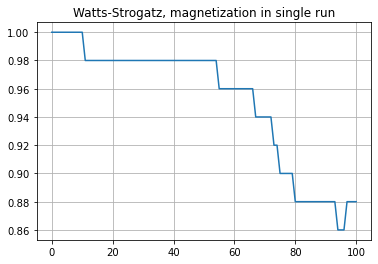

In [99]:
plt.plot(t_gone, m_ops)
plt.title('Watts-Strogatz, magnetization in single run')
plt.grid();

In [100]:
np.vstack([t_gone, t_gone2])

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  7

In [101]:
m_ops_matrix, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
for _ in range(100-1):
    m_ops, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
    m_ops_matrix = np.vstack([m_ops_matrix, m_ops])

In [102]:
np.shape(m_ops_matrix)[1]

1001

In [103]:
m_ops_matrix[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [104]:
len(m_ops_matrix[:,0])

100

In [105]:
len(val_m)

1001

In [106]:
np.mean(m_ops_matrix[0,:])

0.8452947052947054

In [107]:
val_m = [np.mean(m_ops_matrix[:,i]) for i in range(np.shape(m_ops_matrix)[1])]

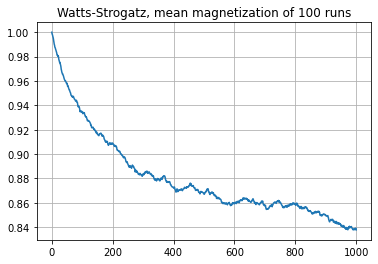

In [108]:
plt.plot(t_gone, val_m)
plt.title('Watts-Strogatz, mean magnetization of 100 runs')
plt.grid();

# 5th dot

In [55]:
from multiprocessing import Pool, cpu_count

cpu_count()

12